In [35]:
# -----------------------------
# === IMPORT STATEMENT ===
# -----------------------------
import os, yaml, base64, time, sys, math, re, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from openai import OpenAI
from matplotlib.patches import Rectangle as rec
from matplotlib.transforms import Affine2D

In [ ]:
# ---------------------------------
# === PARAMETERS & DIRECTORIES ===
# ---------------------------------

OPENAI_API_KEY = "YOUR_API_KEY" # replace with your api key!!
client = OpenAI(api_key = OPENAI_API_KEY)

SCENARIO_ID = "2021_08_23_21_47_19" # change scenario
SCENARIO_SET = "test"    # change scenario sets

BASE = os.getcwd()
LABEL_FILE = f"{BASE}/ID_label/{SCENARIO_SET}/{SCENARIO_ID}/label.txt"
SEG_DIR = f"{BASE}/TEST_ADDITIONAL/nocomms-additional/{SCENARIO_ID}/instance_seg"
FRONT_DIR = f"{BASE}/{SCENARIO_SET}/{SCENARIO_ID}"
FOV_DIR = f"{BASE}/FOV_test/{SCENARIO_ID}"

EVAL_CAV_ID = "243"
HELPER_CAV_ID = "234"
EVAL_INTENTION = "would like to move north"
EVAL_FACING = "north"
CUSTOM_PADDING = True
INTERSECTION_COORDINATES = [35, 66, 4, 30] # format: [min x, max x, min y, max y]
# note: coordinates in the yaml have flipped signs vs the coordinates in the BEV data
# to avoid checking for intersections, set the variable to None

COMBINED_BEV_DIR = f"{BASE}/combined_data/bevs/{SCENARIO_ID}/"
COMBINED_YAML_DIR = f"{BASE}/combined_data/yamls/{SCENARIO_ID}/"
STRUCTURED_FORMAT_DIR = f"{BASE}/structured_format/{SCENARIO_ID}/"
HELPER_SEEN_DIR = f"{FOV_DIR}/"

YOLO_WEIGHTS = "yolov9c.pt"
YOLO_CLASSES = {2, 7}        # car, truck
PIXEL_THRESHOLD = 0          # min pixels for a valid vehicle
IOU_THRESHOLD = 0.0          # IoU for matching YOLO and segmentation boxes


In [ ]:
# -----------------------------
# === HELPER FUNCTIONS ===
# -----------------------------
def ensure_dir(p): os.makedirs(p, exist_ok=True)

def color_to_id(c): r,g,b = c; return r + (g<<8) + (b<<16)

def load_id_map(f):
    id_map = {}
    for line in open(f):
        if line.strip():
            carla, unreal = map(int, line.split())
            id_map[unreal] = carla
    return id_map

def list_nums(path, ext):
    return sorted(int(os.path.splitext(f)[0])
                  for f in os.listdir(path) if f.endswith(ext) and os.path.splitext(f)[0].isdigit())

def map_index(i, total, arr):
    if not arr: return None
    if total <= 1: return arr[0]
    j = int(round(i * (len(arr)-1) / (total-1)))
    return arr[max(0, min(j, len(arr)-1))]

def iou(a,b):
    xA,yA,xB,yB = max(a[0],b[0]), max(a[1],b[1]), min(a[2],b[2]), min(a[3],b[3])
    inter = max(0,xB-xA)*max(0,yB-yA)
    return inter / ( (a[2]-a[0])*(a[3]-a[1]) + (b[2]-b[0])*(b[3]-b[1]) - inter + 1e-6 )

def get_bbox(np_img, color):
    mask = np.all(np_img == color, axis=-1)
    if not np.any(mask): return None
    ys, xs = np.where(mask)
    return [int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max())]

def greedy_match(seen, yolos):
    """Assign YOLO confidences to segmentation boxes via greedy lock-in by pixel area."""
    cids, confs, used = list(seen.keys()), {cid:0.0 for cid in seen}, set()
    cands = {cid:[j for j,(b,_) in enumerate(yolos) if iou(seen[cid]['bbox'],b)>=IOU_THRESHOLD] for cid in cids}
    while True:
        wants = {}
        for cid in cids:
            prefs = [j for j in cands[cid] if j not in used]
            if prefs: wants.setdefault(prefs[0], []).append(cid)
        if not wants: break
        for yidx, cid_list in wants.items():
            win = max(cid_list, key=lambda c: seen[c]['pixels'])
            confs[win] = float(yolos[yidx][1]); used.add(yidx)
    return confs

def list_yaml_ticks(cav_front_dir):
    """Return sorted tick numbers from FRONT_DIR per CAV (accepts plain or yaml/ subdir)."""
    paths = [cav_front_dir, os.path.join(cav_front_dir, "yaml")]
    ticks = set()
    for p in paths:
        if not os.path.isdir(p): continue
        for fn in os.listdir(p):
            base, ext = os.path.splitext(fn)
            if ext.lower() == ".yaml" and base.isdigit():
                ticks.add(int(base))
    return sorted(ticks)

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


In [6]:
# -------------------------------------
# === STAGE 1: Extract visible IDs ===
# -------------------------------------
def stage1_extract_visible_ids():
    ids_map = load_id_map(LABEL_FILE)
    ensure_dir(FOV_DIR)

    cavs = [c for c in sorted(os.listdir(SEG_DIR)) if os.path.isdir(os.path.join(SEG_DIR, c))]
    for cav in cavs:
        seg_cav_dir   = os.path.join(SEG_DIR,   cav)
        front_cav_dir = os.path.join(FRONT_DIR, cav)
        save_dir      = os.path.join(FOV_DIR,   cav)
        ensure_dir(save_dir)

        # discover available frames
        png_numbers = list_nums(seg_cav_dir, ".png")              
        ticks       = list_yaml_ticks(front_cav_dir)            
        if not png_numbers or not ticks:
            print(f"[Stage1] CAV {cav}: no pngs ({len(png_numbers)}) or no ticks ({len(ticks)}). Skipping.")
            continue

        print(f"[Stage1] CAV {cav}: ticks={ticks[0]}..{ticks[-1]} ({len(ticks)}) | pngs={png_numbers[0]}..{png_numbers[-1]} ({len(png_numbers)})")

        last_seen = set()
        for i, tick in enumerate(ticks):
            png_num = map_index(i, len(ticks), png_numbers)   
            img_path = os.path.join(seg_cav_dir, f"{png_num:06}.png")

            visible_ids = set()
            if os.path.isfile(img_path):
                np_img = np.array(Image.open(img_path).convert("RGB"))
                colors, counts = np.unique(np_img.reshape(-1,3), axis=0, return_counts=True)

                for c, cnt in zip(colors, counts):
                    if tuple(c) == (0,0,0) or cnt < PIXEL_THRESHOLD: 
                        continue
                    uid = color_to_id(tuple(c))
                    if uid in ids_map:
                        visible_ids.add(ids_map[uid])

            last_seen = visible_ids or last_seen
            out_path = os.path.join(save_dir, f"{tick}.txt")
            with open(out_path, "w") as f:
                for vid in sorted(last_seen):
                    f.write(f"{vid}\n")

        print(f"[Stage1] CAV {cav}: wrote {len(ticks)} tick files to {save_dir}.")

In [ ]:
# -----------------------------
# === STAGE 2: Filter YAMLs ===
# -----------------------------
def stage2_filter_yamls(debug=True):
    for cav in sorted(os.listdir(FOV_DIR)):
        cav_dir = os.path.join(FOV_DIR, cav)
        if not os.path.isdir(cav_dir):
            continue

        yaml_out = os.path.join(cav_dir, "yaml")
        ensure_dir(yaml_out)

        txts = sorted(f for f in os.listdir(cav_dir) if f.endswith(".txt"))
        if debug:
            print(f"[Stage2] CAV={cav} txt_count={len(txts)} out={yaml_out}")

        wrote = 0
        for txt in txts:
            tick = os.path.splitext(txt)[0]
            try:
                tick_int = int(tick)
            except:
                if debug:
                    print(f"  [skip] non-numeric tick filename: {txt}")
                continue
            tick_pad = f"{tick_int:06d}"
            txt_path = os.path.join(cav_dir, txt)

            # Try multiple YAML search paths and filename forms
            candidates = [
                os.path.join(FRONT_DIR, cav, f"{tick}.yaml"),
                os.path.join(FRONT_DIR, cav, f"{tick_pad}.yaml"),
                os.path.join(FRONT_DIR, cav, "yaml", f"{tick}.yaml"),
                os.path.join(FRONT_DIR, cav, "yaml", f"{tick_pad}.yaml"),
                os.path.join(FRONT_DIR, cav, f"{tick}.yml"),
                os.path.join(FRONT_DIR, cav, f"{tick_pad}.yml"),
                os.path.join(FRONT_DIR, cav, "yaml", f"{tick}.yml"),
                os.path.join(FRONT_DIR, cav, "yaml", f"{tick_pad}.yml"),
            ]
            y_in = next((p for p in candidates if os.path.isfile(p)), None)
            if not y_in:
                if debug:
                    print(f"  [miss] tick={tick} (no YAML found)")
                continue

            # Read visible IDs from txt file
            with open(txt_path) as f:
                visible_raw = [ln.strip().strip("'\"") for ln in f if ln.strip()]

            # Normalize visible IDs to integer-based strings
            visible = set()
            for v in visible_raw:
                try:
                    visible.add(str(int(v)))   
                except:
                    visible.add(v)

            # Load YAML and filter vehicles
            try:
                with open(y_in) as f:
                    y = yaml.safe_load(f) or {}
            except Exception as e:
                if debug:
                    print(f"  [err] Failed to read {y_in}: {e}")
                continue

            vehicles_all = y.get("vehicles", {}) or {}

            # Normalize YAML keys as well for matching
            filtered = {}
            for k, v in vehicles_all.items():
                try:
                    norm_key = str(int(k))
                except:
                    norm_key = k
                if norm_key in visible or k in visible:
                    filtered[k] = v

            y["vehicles"] = filtered
            out_path = os.path.join(yaml_out, f"{tick_pad}.yaml")
            with open(out_path, "w") as f:
                yaml.safe_dump(y, f, sort_keys=False)

            wrote += 1
            if debug:
                print(f"  [ok] tick={tick} -> {os.path.basename(out_path)}  "
                      f"visible={len(visible)} matched={len(filtered)}")

        print(f"[Stage2] CAV {cav}: wrote {wrote} filtered YAMLs.\n")

In [ ]:
# -----------------------------
# === STAGE 3: Add YOLO Confidences ===
# -----------------------------

def stage3_add_confidences(debug=True, debug_images=False):
    ids_map = load_id_map(LABEL_FILE)
    yolo = YOLO(YOLO_WEIGHTS)

    for cav in sorted(os.listdir(FOV_DIR)):
        cav_dir = os.path.join(FOV_DIR, cav)
        y_dir = os.path.join(cav_dir, "yaml")
        if not os.path.isdir(y_dir):
            continue

        seg_dir = os.path.join(SEG_DIR, cav)
        ticks, pngs = list_nums(y_dir, ".yaml"), list_nums(seg_dir, ".png")
        if not ticks or not pngs:
            print(f"[Stage3] Skipping {cav}: missing yaml or seg data.")
            continue

        print(f"[Stage3] CAV {cav}: {len(ticks)} YAMLs, {len(pngs)} seg frames.")
        out_vis = os.path.join(FOV_DIR, cav, "vis")
        if debug_images:
            ensure_dir(out_vis)

        for i, t in enumerate(ticks):
            seg_num = map_index(i, len(ticks), pngs)
            seg_path = os.path.join(seg_dir, f"{seg_num:06}.png")
            front_path = os.path.join(FRONT_DIR, cav, f"{t:06}_camera0.png")
            yaml_path = os.path.join(y_dir, f"{t:06}.yaml")
            if not os.path.isfile(yaml_path):
                continue

            # collect segmentation boxes
            seen = {}
            if os.path.isfile(seg_path):
                np_img = np.array(Image.open(seg_path).convert("RGB"))
                colors, counts = np.unique(np_img.reshape(-1, 3), axis=0, return_counts=True)
                for c, cnt in zip(colors, counts):
                    if tuple(c) == (0, 0, 0) or cnt < PIXEL_THRESHOLD:
                        continue
                    uid = color_to_id(tuple(c))
                    if uid not in ids_map:
                        continue
                    cid = ids_map[uid]
                    bbox = get_bbox(np_img, tuple(c))
                    if bbox:
                        seen[str(cid)] = {"bbox": bbox, "pixels": cnt, "conf": 0.0}

            # YOLO detections 
            yolo_boxes = []
            if os.path.isfile(front_path):
                res = yolo(front_path, verbose=False)[0]
                for b in res.boxes:
                    if int(b.cls) in YOLO_CLASSES:
                        yolo_boxes.append((b.xyxy.cpu().numpy().flatten().tolist(), float(b.conf)))

            # IoU matching 
            matched_conf = {}
            for cid, seg in seen.items():
                best_conf = 0.0
                for yb, conf in yolo_boxes:
                    if iou(seg["bbox"], yb) >= IOU_THRESHOLD:
                        best_conf = max(best_conf, conf)
                matched_conf[cid] = best_conf
                seen[cid]["conf"] = best_conf

            # update YAML
            with open(yaml_path) as f:
                y = yaml.safe_load(f) or {}
            vehicles = y.get("vehicles", {})
            matched = 0
            for k, v in vehicles.items():
                norm_k = str(int(k))
                if norm_k in matched_conf:
                    v["confidence"] = float(matched_conf[norm_k])
                    matched += 1
            y["vehicles"] = vehicles
            with open(yaml_path, "w") as f:
                yaml.safe_dump(y, f, sort_keys=False)

        print(f"[Stage3] CAV {cav} confidence updated.\n")

In [ ]:

# --------------------------------------
# === EXECUTION EXTRACTING FOV INFO ===
# --------------------------------------
stage1_extract_visible_ids()
stage2_filter_yamls()
stage3_add_confidences()
print("All stages complete.")

In [ ]:
# -------------------------------------------------------------
# === STAGE 4: Generate Structured Format via Combined Data ===
# -------------------------------------------------------------

def stage4_generate_structured_format():
    root_data_dir = FOV_DIR + f"/"
    eval_view_dir = FRONT_DIR + f"/{EVAL_CAV_ID}"
    helper_cav_id = HELPER_CAV_ID
    eval_cav_id = EVAL_CAV_ID
    helper_seen_dir = FOV_DIR + f"/{HELPER_CAV_ID}"
    eval_seen_dir = FOV_DIR + f"/{EVAL_CAV_ID}"
    eval_intention = EVAL_INTENTION
    eval_facing = EVAL_FACING
    # outputs
    out_dir = STRUCTURED_FORMAT_DIR
    bev_path_dir = COMBINED_BEV_DIR
    yaml_path_dir = COMBINED_YAML_DIR

    def test_eval_with_prompt(prompt_str, timestamp):
        base64_image_eval = encode_image(eval_view_dir + str(timestamp).zfill(6) + "_camera0.png")
        try:
            base64_image_bev = encode_image(bev_path_dir + str(timestamp) + ".png")
        except:
            base64_image_bev = encode_image(bev_path_dir + str(timestamp).zfill(6) + ".png")
        
        start_time = time.time()
    
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt_str},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image_bev}",
                            },
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image_eval}",
                            },
                        },
                    ],
                }
            ],
            max_tokens=500,
            seed=42,
            temperature=0.0000001
        )
        
        end_time = time.time()
        return({"time_taken": end_time-start_time, "response": response.choices[0].message.content})

    # BEV Gen

    bev_gen_out_dir = bev_path_dir
    yaml_gen_out_dir = yaml_path_dir
    FOV_ROOT = root_data_dir

    def ensure_dir(path):
        if not os.path.exists(path):
            os.makedirs(path)

    cav_ids = [eval_cav_id, helper_cav_id] # EVAL IS 0

    yaml_dir_0 = os.path.join(FOV_ROOT, str(cav_ids[0]), "yaml")
    yaml_dir_1 = os.path.join(FOV_ROOT, str(cav_ids[1]), "yaml")
    ensure_dir(bev_gen_out_dir)
    ensure_dir(yaml_gen_out_dir)
    ensure_dir(yaml_dir_0)
    ensure_dir(yaml_dir_1)
    ensure_dir(out_dir)

    ticks = sorted([f.replace(".yaml", "") for f in os.listdir(yaml_dir_0) if f.endswith(".yaml")])

    with open(os.path.join(yaml_dir_0, f"{ticks[0]}.yaml")) as f:
        data_0 = yaml.safe_load(f)

    with open(os.path.join(yaml_dir_1, f"{ticks[0]}.yaml")) as f:
        data_1 = yaml.safe_load(f)

    min_x, max_x = float('inf'), float('-inf')
    min_y, max_y = float('inf'), float('-inf')

    x, y = data_0["true_ego_pos"][:2]
    x = -x
    min_x = min(min_x, x)
    max_x = max(max_x, x)
    min_y = min(min_y, y)
    max_y = max(max_y, y)

    x, y = data_1["true_ego_pos"][:2]
    x = -x
    min_x = min(min_x, x)
    max_x = max(max_x, x)
    min_y = min(min_y, y)
    max_y = max(max_y, y)

    for bg_info in data_0.get("vehicles", {}).values():
        bx, by = bg_info["location"][:2]
        bx = -bx
        min_x = min(min_x, bx)
        max_x = max(max_x, bx)
        min_y = min(min_y, by)
        max_y = max(max_y, by)

    for bg_info in data_1.get("vehicles", {}).values():
        bx, by = bg_info["location"][:2]
        bx = -bx
        min_x = min(min_x, bx)
        max_x = max(max_x, bx)
        min_y = min(min_y, by)
        max_y = max(max_y, by)

    padding = 30
    min_x -= padding
    max_x += padding
    min_y -= padding
    max_y += padding

    if (CUSTOM_PADDING): # it is helpful, though not necessary, to define manual padding boundaries per scenario
        min_x = min(min_x, 30)
        max_y = max(max_y, 30)

    for tick in ticks:
        yaml_path_0 = os.path.join(yaml_dir_0, f"{tick}.yaml")
        with open(yaml_path_0) as f:
            data_0 = yaml.safe_load(f)

        yaml_path_1 = os.path.join(yaml_dir_1, f"{tick}.yaml")
        with open(yaml_path_1) as f:
            data_1 = yaml.safe_load(f)

        combined_vehicle_dict = {**data_0.get("vehicles", {}), **data_1.get("vehicles", {})}

        combined_yaml = {
            "true_ego_pos": data_0.get("true_ego_pos", []),
            "ego_speed": data_0.get("ego_speed", -1.0),
            "true_helper_pos": data_1.get("true_ego_pos", []),
            "helper_speed": data_1.get("ego_speed", -1.0),
            "vehicles": {
                str(vid): info for vid, info in combined_vehicle_dict.items()
            }
        }

        combined_yaml_out_path = os.path.join(yaml_gen_out_dir, f"{tick}.yaml")
        with open(combined_yaml_out_path, "w") as f:
            yaml.dump(combined_yaml, f)
        if (int(tick) % 3 == 0):
            print(f"[Saved] {combined_yaml_out_path}")

        fig, ax = plt.subplots(figsize=(10, 10))

        helper_drawn_as_seen = False

        # Plot ego A
        x, y = data_0["true_ego_pos"][:2]
        x = -x
        yaw = -np.deg2rad(data_0["true_ego_pos"][4])
        tform = Affine2D().rotate_around(x, y, yaw)
        rect = rec((x - 2.25, y - 1), 4.5, 2, facecolor='pink', edgecolor='pink', transform=tform + ax.transData)
        ax.add_patch(rect)
        ax.plot([x, x + 2 * np.cos(yaw)], [y, y + 2 * np.sin(yaw)], color='pink')
        ax.text(x, y, cav_ids[0], ha='center', va='center', fontsize=12, color='black')

        # Plot ego B
        x, y = data_1["true_ego_pos"][:2]
        x = -x
        yaw = -np.deg2rad(data_1["true_ego_pos"][4])
        tform = Affine2D().rotate_around(x, y, yaw)
        rect = rec((x - 2.25, y - 1), 4.5, 2, facecolor='pink', edgecolor='pink', transform=tform + ax.transData)
        ax.add_patch(rect)
        ax.plot([x, x + 2 * np.cos(yaw)], [y, y + 2 * np.sin(yaw)], color='pink')
        ax.text(x, y, cav_ids[1], ha='center', va='center', fontsize=12, color='black')

        # Plot background vehicles
        dict_0 = data_0.get("vehicles", {})
        for bg_id, bg_info in dict_0.items():
            if (str(bg_id) in cav_ids):
                continue

            x, y = bg_info["location"][:2]
            x = -x
            yaw = -np.deg2rad(bg_info["angle"][1])
            tform = Affine2D().rotate_around(x, y, yaw)
            rect = rec((x - 2.25, y - 1), 4.5, 2,
                        facecolor='yellow', edgecolor='yellow', alpha=0.7,
                        transform=tform + ax.transData)
            ax.add_patch(rect)
            ax.plot([x, x + 2 * np.cos(yaw)], [y, y + 2 * np.sin(yaw)], color='yellow')
            ax.text(x, y, str(bg_id), ha='center', va='center', fontsize=12, color='black')
        
        dict_1 = data_1.get("vehicles", {})
        for bg_id, bg_info in dict_1.items():
            if ((bg_id in dict_0) or (str(bg_id) in cav_ids)):
                continue

            x, y = bg_info["location"][:2]
            x = -x
            yaw = -np.deg2rad(bg_info["angle"][1])
            tform = Affine2D().rotate_around(x, y, yaw)
            rect = rec((x - 2.25, y - 1), 4.5, 2,
                        facecolor='yellow', edgecolor='yellow', alpha=0.7,
                        transform=tform + ax.transData)
            ax.add_patch(rect)
            ax.plot([x, x + 2 * np.cos(yaw)], [y, y + 2 * np.sin(yaw)], color='yellow')
            ax.text(x, y, str(bg_id), ha='center', va='center', fontsize=12, color='black')

        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)
        ax.set_aspect('equal')
        plt.title(f"Tick {tick} | CAVs {cav_ids[0]} (EGO) and {cav_ids[1]} (HELPER)")
        plt.savefig(os.path.join(bev_gen_out_dir, f"{tick}.png"), dpi=300)
        plt.close()
        #if (int(tick) % 3 == 0):
        #    print(f"[Saved] {bev_gen_out_dir}/{tick}.png")

    print("> BEV and YAML generation complete.")

    ticks.sort()

    directions_global = ['E', 'ENE', 'NE', 'NNE', 'N', 'NNW', 'NW', 'WNW', 'W', 'WSW', 'W', 'SSW', 'S', 'SSE', 'SE', 'ESE']

    all_times_taken_sum = 0.0
    all_times_taken_num = 0

    for tick in ticks:
        # Prompts may need to be modified slightly depending on the scenario (ex, description of CAV behavior)
        eval = test_eval_with_prompt(
            f"""You are an AI assistant that helps with safe driving from a high-level perspective. 
            You are working with a scenario in which there are some autonomous cars and many regular cars. 
            You must refer to them by their IDs, which are used to label them. 

            You are provided with two images: 
            - a birds-eye view of an intersection with some autonomous cars and some regular cars; 
            - the front view of Vehicle {eval_cav_id}, called the Ego CAV. 

            In the birds-eye view, the autonomous cars are colored pink and the regular cars are colored yellow. 
            You must refer to them by their IDs, which are used to label them. 
            Directions on this map are given as you see them: North is up, South is down, East is right, West is left. 

            The vehicle of interest in this scenario is Vehicle {eval_cav_id}, called the Ego CAV. It currently {eval_intention}. It is currently facing {eval_facing}. 

            Your task is to discern which vehicles might interfere with the motion of the Ego CAV such that it should know about them in order to make a safe decision.
            When including relevant vehicles, try to think forward in time and consider how the vehicles may interact over the next few seconds or whether their paths could potentially intersect.
            At the end of your response, you must include a space-separated list of the vehicle IDs of interest in this EXACT format:

            id_1 id_2 ... id_n

            Or, only if there are no vehicle IDs of interest, include at the end of your response the number:

            0
            
            """,
            int(tick)
        )

        # NOTE:positions are given relative to ego's north; may misalign with bev in scene 2 since it turns
        # (positions are still correct but may confuse vlm)

        time_taken_this_tick = eval['time_taken']
        all_times_taken_num += 1
        all_times_taken_sum += time_taken_this_tick
        nearby_list = eval['response']
        nearby_list_lines = nearby_list.strip().splitlines()

        def describe_relative_direction(ego_x, ego_y, ego_yaw, other_x, other_y, other_yaw):
            directions = ['E', 'ENE', 'NE', 'NNE', 'N', 'NNW', 'NW', 'WNW', 'W', 'WSW', 'W', 'SSW', 'S', 'SSE', 'SE', 'ESE']
            
            dx = other_x - ego_x
            dy = other_y - ego_y

            distance_val = math.sqrt(dx*dx + dy*dy)
            if (distance_val < 6):
                distance = "very close"
            elif (distance_val < 10):
                distance = "close"
            elif (distance_val < 15):
                distance = "somewhat far"
            else:
                distance = "far"

            relative_angle = math.atan2(dy,dx)
            relative_angle += (math.pi/2 - ego_yaw)
            relative_angle += math.pi # correction for sim data
            if (relative_angle < 0):
                relative_angle += 2*math.pi
            
            rel_dir = directions[int((relative_angle + math.pi/16) / (math.pi/8)) % 16]

            relative_yaw = (math.pi/2 - ego_yaw) + other_yaw
            if (relative_yaw < 0):
                relative_yaw += 2 * math.pi

            facing = directions[int((relative_yaw + math.pi/16)/(math.pi/8)) % 16]

            return (rel_dir, distance_val, distance, facing)

        try:
            matches = re.findall(r'\d+', nearby_list_lines[-1])
        except:
            print("ERROR: GPT output did not conform to the format. Output was:")
            print(nearby_list)
            matches = []
        
        id_list = [int(match) for match in matches]

        if (id_list):
            if (id_list[0] == 0):
                id_list = []
        else:
            id_list = []

        with open(yaml_path_dir + tick + ".yaml") as f:
            yaml_data = yaml.safe_load(f)

        vehicle_dict = yaml_data.get("vehicles", {})
        ego_x, ego_y = yaml_data["true_ego_pos"][:2]
        ego_x = -ego_x
        ego_yaw = -np.deg2rad(yaml_data["true_ego_pos"][4])
        ego_speed = yaml_data["ego_speed"]
        helper_x, helper_y = yaml_data["true_helper_pos"][:2]
        helper_x = -helper_x
        helper_yaw = -np.deg2rad(yaml_data["true_helper_pos"][4])
        helper_speed = yaml_data["helper_speed"]

        final_structure_str = ""

        #if (SCENE_TO_USE in [4, 4.5]):
        ego_facing = directions_global[int((ego_yaw + math.pi/16)/(math.pi/8)) % 16]
        final_structure_str += f"Ego Vehicle: Facing {ego_facing}, Speed: {ego_speed}\n"

        for id in id_list:
            strid = str(id)
            
            if (strid in vehicle_dict):
                info = vehicle_dict[strid]
                other_x, other_y = info["location"][:2]
                other_x = -other_x
                other_yaw = -np.deg2rad(info["angle"][1])
                rel_dir, distance_val, distance, facing = describe_relative_direction(ego_x, ego_y, ego_yaw, other_x, other_y, other_yaw)
                speed_num = info["speed"]
                confidence_num = 0.0
                try:
                    confidence_num = info['confidence']
                except:
                    confidence_num = 0.0
                if (speed_num < 1):
                    speed = "stopped"
                elif (speed_num < 5): # This threshold is arbitrary and may be worth adjusting to your specific scenario
                    speed = "slow"
                else:
                    speed = "fast"

                if (confidence_num > 0.5):

                    # check for possible imminent collision
                    # assume ego speed = other car's speed
                    speed_num *= -1

                    # ego: ego_x, ego_y, ego_yaw, speed_num
                    # other: other_x, other_y, other_yaw, speed_num
                    # 1s threshold

                    A= np.array([
                        [speed_num*np.cos(other_yaw),-speed_num*np.cos(ego_yaw)],
                        [speed_num*np.sin(other_yaw),-speed_num*np.sin(ego_yaw)]
                    ])
                    b=np.array([ego_x-other_x,ego_y-other_y])
                    try:
                        t=np.linalg.solve(A,b)
                        t2=t[1]
                        t1=t[0]
                        final_structure_str += f"Vehicle {id} (perception confidence {confidence_num:.2f}): Relative direction to Ego CAV: {rel_dir}, Distance: {distance_val} ({distance}), Facing {facing}, Speed: {speed}"
                        if (INTERSECTION_COORDINATES):
                            if((other_x > INTERSECTION_COORDINATES[0]) and (other_x < INTERSECTION_COORDINATES[1]) and (other_y > INTERSECTION_COORDINATES[2]) and (other_y < INTERSECTION_COORDINATES[3])):
                                final_structure_str += f" - NOTE: This vehicle is in the intersection"
                        if(abs(t2-t1)<0.5 and t1>0 and t2>0 and ((t1+t2)/2 < 0.5)):
                            final_structure_str += f" - WARNING: Collision with this car potentially imminent"
                        final_structure_str += "\n"
                    except np.linalg.LinAlgError:
                        final_structure_str += f"Vehicle {id} (perception confidence {confidence_num:.2f}): Relative direction to Ego CAV: {rel_dir}, Distance: {distance_val} ({distance}), Facing {facing}, Speed: {speed}\n"
            elif (strid == str(helper_cav_id)):
                other_x = helper_x
                other_y = helper_y
                other_yaw = helper_yaw
                rel_dir, distance_val, distance, facing = describe_relative_direction(ego_x, ego_y, ego_yaw, other_x, other_y, other_yaw)
                speed_num = helper_speed
                confidence_num = 1.0 # helper can guarantee its own presence
                
                if (speed_num < 1):
                    speed = "stopped"
                elif (speed_num < 5):
                    speed = "slow"
                else:
                    speed = "fast"

                if (confidence_num > 0.5):

                    # check for possible imminent collision
                    # assume ego speed = other car's speed
                    speed_num *= -1

                    # ego: ego_x, ego_y, ego_yaw, speed_num
                    # other: other_x, other_y, other_yaw, speed_num
                    # 1s threshold

                    A= np.array([
                        [speed_num*np.cos(other_yaw),-speed_num*np.cos(ego_yaw)],
                        [speed_num*np.sin(other_yaw),-speed_num*np.sin(ego_yaw)]
                    ])
                    b=np.array([ego_x-other_x,ego_y-other_y])
                    try:
                        t=np.linalg.solve(A,b)
                        t2=t[1]
                        t1=t[0]
                        final_structure_str += f"Vehicle {id} (perception confidence {confidence_num:.2f}): Relative direction to Ego CAV: {rel_dir}, Distance: {distance_val} ({distance}), Facing {facing}, Speed: {speed}"
                        if (INTERSECTION_COORDINATES):
                            if((other_x > INTERSECTION_COORDINATES[0]) and (other_x < INTERSECTION_COORDINATES[1]) and (other_y > INTERSECTION_COORDINATES[2]) and (other_y < INTERSECTION_COORDINATES[3])):
                                final_structure_str += f" - NOTE: This vehicle is in the intersection"
                        if(abs(t2-t1)<0.5 and t1>0 and t2>0 and ((t1+t2)/2 < 0.5)):
                            final_structure_str += f" - WARNING: Collision with this car potentially imminent"
                            print("*", end=" ")
                        final_structure_str += "\n"
                    except np.linalg.LinAlgError:
                        final_structure_str += f"Vehicle {id} (perception confidence {confidence_num:.2f}): Relative direction to Ego CAV: {rel_dir}, Distance: {distance_val} ({distance}), Facing {facing}, Speed: {speed}\n"
            else:
                final_structure_str += f"Vehicle {id}: Not found\n"

        with open(out_dir + tick + ".txt", "w") as outfile:
            outfile.write(final_structure_str)

        print(f"Done with {tick}")

    average_time_taken = all_times_taken_sum / float(all_times_taken_num)

    print(f">> AVERAGE TIME TAKEN: {average_time_taken}")

In [ ]:
# --------------------------------------------
# === EXECUTION GENERATING STRUCTURED DATA ===
# --------------------------------------------
stage4_generate_structured_format()
print("All stages complete.")

(Add your code here for starting the Carla simulator.)

In [ ]:
# 1. Set CARLA_ROOT (absolute path)
os.environ['CARLA_ROOT'] = '/opt/carla-simulator'
print(f"CARLA_ROOT: {os.environ['CARLA_ROOT']}")

# 2. Set SCENARIO_RUNNER_ROOT (convert to absolute!)
scenario_runner_relative = '../simulation/scenario_runner'
scenario_runner_absolute = os.path.abspath(scenario_runner_relative)
os.environ['SCENARIO_RUNNER_ROOT'] = scenario_runner_absolute
print(f"SCENARIO_RUNNER_ROOT: {os.environ['SCENARIO_RUNNER_ROOT']}")

# 3. Get project root
project_root = os.getcwd()
print(f"Project root: {project_root}")

# 4. Add to Python path
paths_to_add = [
    project_root,
    f"{os.environ['CARLA_ROOT']}/PythonAPI/carla/dist/carla-0.9.13-py3.7-linux-x86_64.egg",
    f"{os.environ['CARLA_ROOT']}/PythonAPI/carla",
    os.environ['SCENARIO_RUNNER_ROOT'],
]

for path in reversed(paths_to_add):
    if path not in sys.path:
        sys.path.insert(0, path)

os.environ['PYTHONPATH'] = ":".join(sys.path)

In [ ]:
cd ../OpenCOOD
!python logreplay/scenario/scenario_record.py

In [61]:
# Ensure the recording was correctly saved
import os

recording_dir = "./logreplay/scenario/metric_record/recording_2021_08_23_21_47_19.log"

if os.path.exists(recording_dir):
    print("Recording exists")
else:
    print("Recording does not exist")


Recording exists


In [ ]:
cd ../simulation/scenario_runner/

(Add your code here to restart the Carla simulator.)

In [63]:
#../../OpenCOOD/logreplay/scenario/metric_record/recording_2021_08_23_21_47_19.log

# Ensure the recording was correctly saved
import os

recording_dir = "../../OpenCOOD/logreplay/scenario/metric_record/recording_2021_08_23_21_47_19.log"

if os.path.exists(recording_dir):
    print("Recording exists")
else:
    print("Recording does not exist")


Recording exists


In [69]:
!python metrics_manager.py   --log ../../OpenCOOD/logreplay/scenario/metric_record/recording_2021_08_23_21_47_19.log   --metric srunner/metrics/examples/distance_between_allego.py

[DistanceBetweenVehicles] Saved -> ../../OpenCOOD/logreplay/scenario/metric_results/example.distance_between_vehicles.json
Figure(640x480)


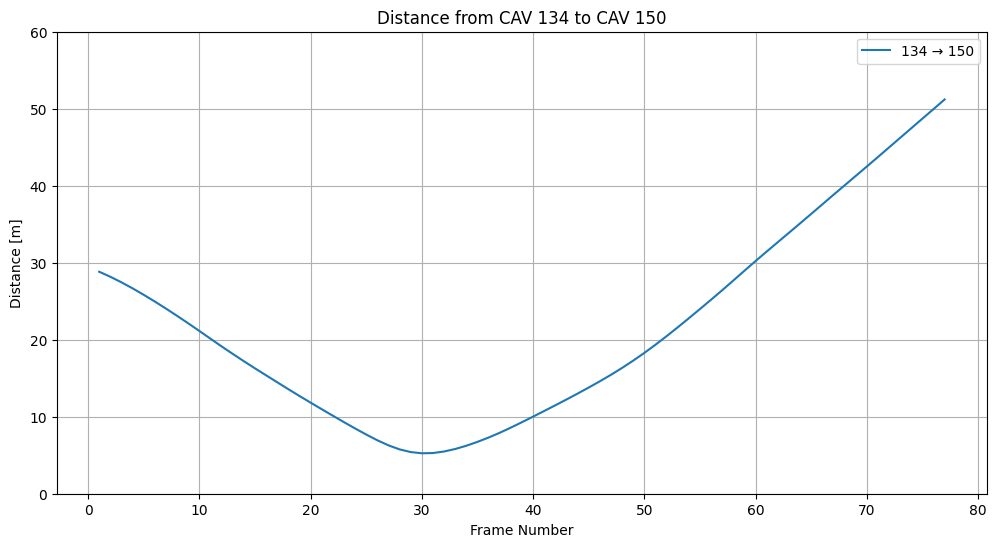

Distance range: 5.25m - 51.20m


In [ ]:
import json
import os
import matplotlib.pyplot as plt

DISTANCE_JSON_PATH = "../../OpenCOOD/logreplay/scenario/metric_results/example.distance_between_vehicles.json"

with open(DISTANCE_JSON_PATH, 'r') as f:
    distances = json.load(f)

# Actual IDs in the data
ego_id = "63"
target_id = "79"

# Labels to display in the plot
display_ego = "134"
display_target = "150"

if ego_id in distances and target_id in distances[ego_id]:
    frames_dict = distances[ego_id][target_id]
    
    frames, dists = zip(*sorted((int(frame), dist) for frame, dist in frames_dict.items()))
    
    plt.figure(figsize=(12, 6))
    plt.plot(frames, dists, label=f"{display_ego} → {display_target}")
    plt.title(f"Distance from CAV {display_ego} to CAV {display_target}")
    plt.xlabel("Frame Number")
    plt.ylabel("Distance [m]")
    plt.legend(loc='upper right')
    plt.grid(True)
    
    max_dist = max(dists)
    upper_limit = int((max_dist + 9) // 10) * 10
    plt.ylim(0, upper_limit)
    plt.yticks(range(0, upper_limit + 1, 10))
    
    plt.show() 
    
    print(f"Distance range: {min(dists):.2f}m - {max(dists):.2f}m")
else:
    print(f"No distance data found between CAV {ego_id} and CAV {target_id}")